# Planar Data Classification with One Hidden Layer

Previously we tried making a neural network using ogistic regression, now lets see the difference if we add in one hidden layer.

#### Package Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

#### Choose Dataset

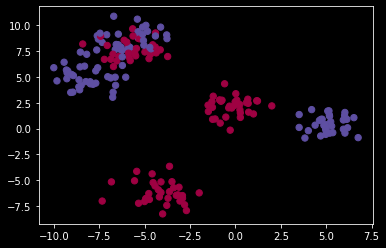

In [2]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "blobs"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.style.use(["dark_background"])
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

#### Plot Dataset

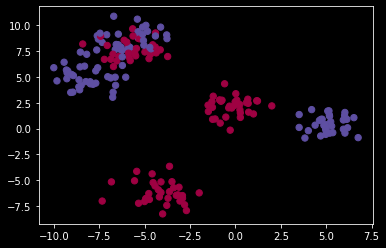

In [3]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

#### Shape and Size Inspection

In [4]:
shape_X = X.shape
shape_Y = Y.shape
m = (X.size)/shape_X[0]  # training set size


print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 200)
The shape of Y is: (1, 200)
I have m = 200 training examples!


#### Train LogReg on Data

We'd like to see how god LogReg does on this data

In [5]:
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

C:\Users\zakki\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#### Plot Predicted Decision Boundary

Accuracy of logistic regression: 60 % (percentage of correctly labelled datapoints)


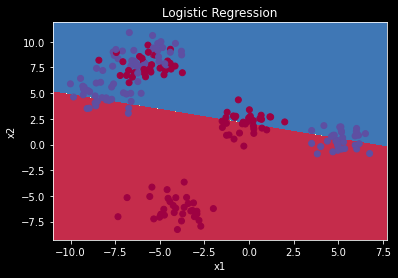

In [6]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

#### Model Architecture

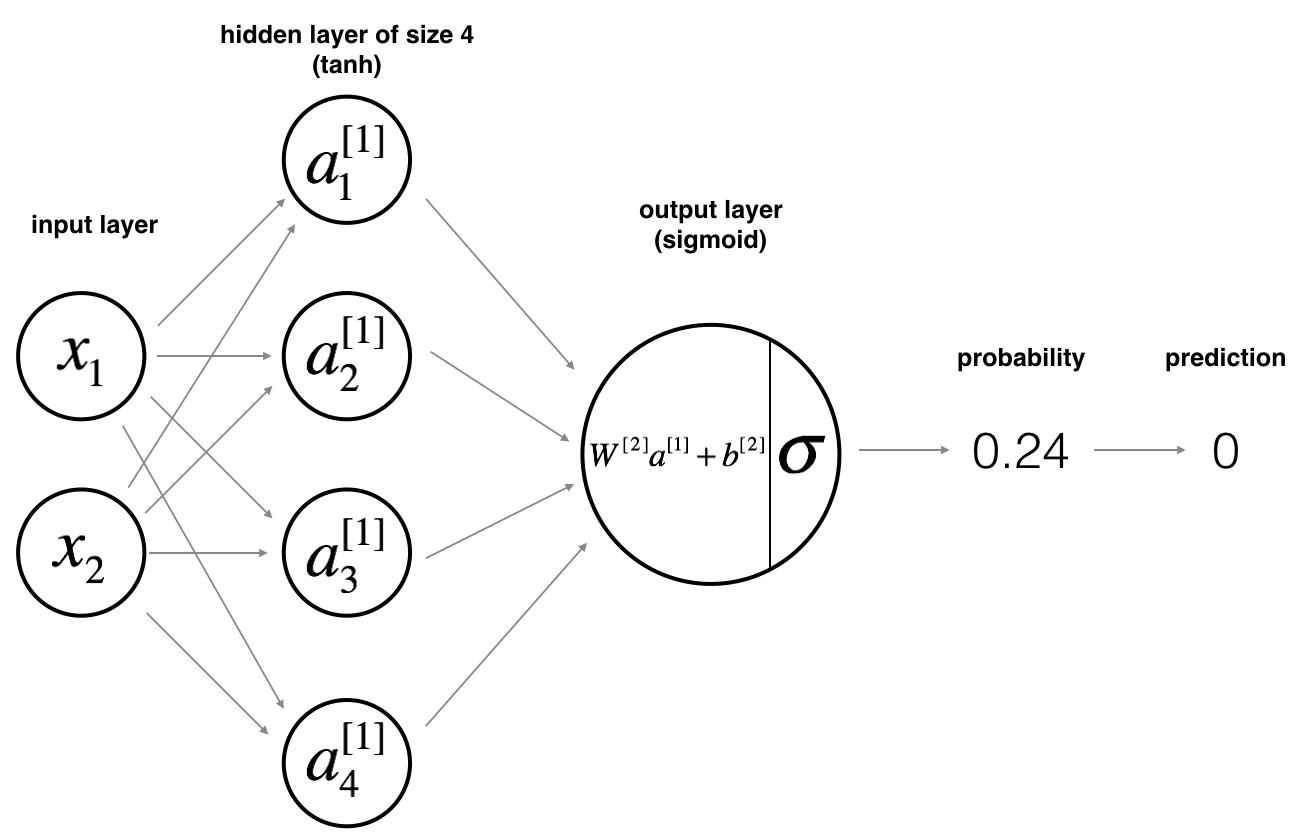

#### Maths

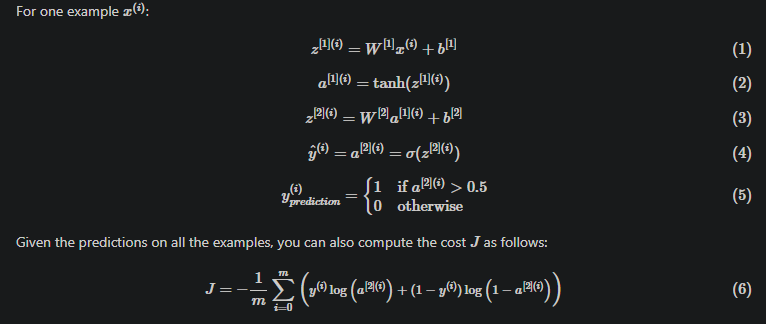

tanh the weighted inputs + some bias to get an activation function (in the hidden layer), which you then weigh and add some bias to before tanh'ing it to get a probability for classification. Then of course you compute the cost.

General NN workflow is;
- Define NN structure
- Initialize model parameters
- Loop:
    - Forward prop
    - Compute loss
    - Backward prop to get the changes (gradients)
    - Update parameters (gradient descent)

#### Defining NN Structure

In [7]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

In [8]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


#### Initialize parameters

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


#### Forward Propagation

In [11]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    # Values needed in the backpropagation are stored in "cache". This will be given as an input to the backpropagation
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [12]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


#### Compute Cost

In [13]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    [Note that the parameters argument is not used in this function, 
    but the auto-grader currently expects this parameter.
    Future version of this notebook will fix both the notebook 
    and the auto-grader so that `parameters` is not needed.
    For now, please include `parameters` in the function signature,
    and also when invoking this function.]
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = logprobs = np.multiply(Y ,np.log(A2)) + np.multiply((1-Y), np.log(1-A2))
    cost = (-1/m) * np.sum(logprobs)
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [14]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6930587610394646


#### Backward Propagation

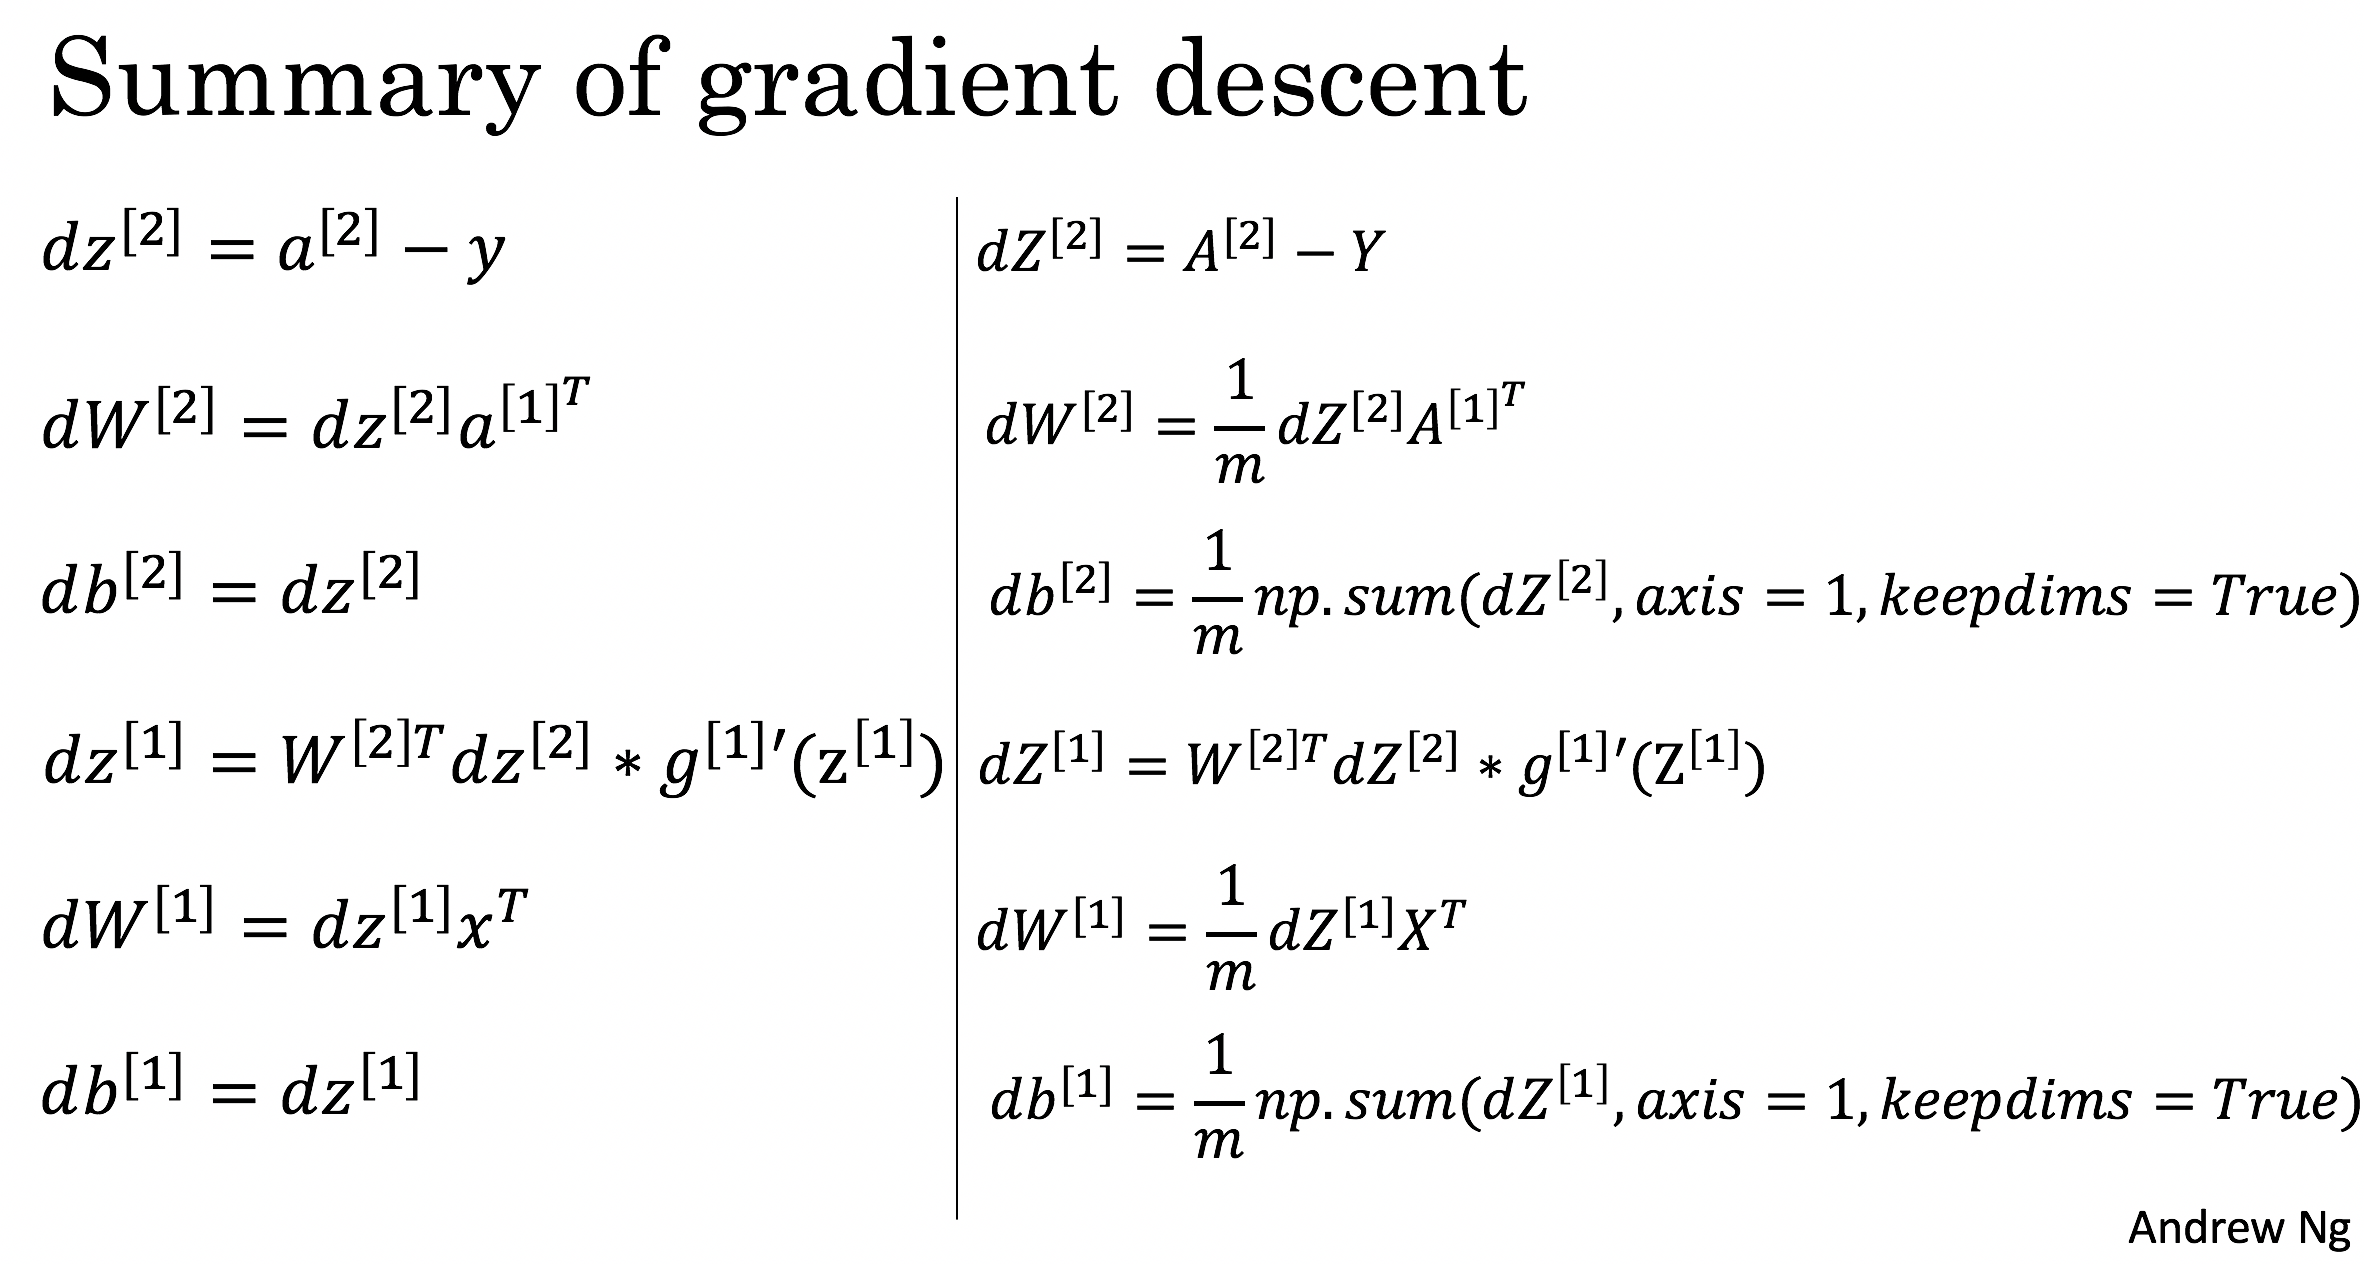

Basically tuning the weights and biases for better prediction accuracy by comparing desired outputs to achieved system outputs.

In [15]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2,A1.T)
    db2 = (1/m) *(np.sum(dZ2,axis=1,keepdims=True))
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1,2))
    dW1 = (1/m) *(np.dot(dZ1,X.T))
    db1 = (1/m) *(np.sum(dZ1, axis=1, keepdims=True))
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [16]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


#### Update Parameters

Gradient descent with a good learning rate; converges.

![SegmentLocal](sgd.gif "segment")

Gradient descent with a bad learning rate; diverges.

![SegmentLocal](sgd_bad.gif "segment")

In [17]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [18]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads,1.2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


#### Model

In [19]:
# NN_model
def nn_model(X, Y, n_h, learning_rate, num_iterations = 10000, print_cost=False):
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost"
        cost = compute_cost(A2, Y, parameters)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads"
        grads = backward_propagation(parameters, cache, X, Y)
        # Update rule for each parameter
        parameters = update_parameters(parameters, grads, learning_rate)
        # If print_cost=True, Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    # Returns parameters learnt by the model. They can then be used to predict output
    return parameters

In [20]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, 1.02,num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000257
Cost after iteration 2000: 0.000127
Cost after iteration 3000: 0.000084
Cost after iteration 4000: 0.000063
Cost after iteration 5000: 0.000050
Cost after iteration 6000: 0.000042
Cost after iteration 7000: 0.000036
Cost after iteration 8000: 0.000031
Cost after iteration 9000: 0.000028
W1 = [[-0.65400312  1.21068652]
 [-0.75688005  1.38443617]
 [ 0.57449374 -1.0957478 ]
 [ 0.76242342 -1.40517716]]
b1 = [[ 0.2841426 ]
 [ 0.34699428]
 [-0.23981061]
 [-0.35351855]]
W2 = [[-2.42329584 -3.22274999  1.97978376  3.31771228]]
b2 = [[0.20282644]]


#### Predict

In [21]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    
    return predictions

In [22]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


Cost after iteration 0: 0.693527
Cost after iteration 1000: 0.323872
Cost after iteration 2000: 0.363285
Cost after iteration 3000: 0.324242
Cost after iteration 4000: 0.323546
Cost after iteration 5000: 0.323270
Cost after iteration 6000: 0.323119
Cost after iteration 7000: 0.323023
Cost after iteration 8000: 0.322957
Cost after iteration 9000: 0.322908


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

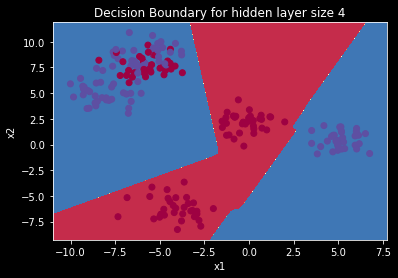

In [23]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, 4, 1.2 , num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [24]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 83%


#### Tuning Hidden Layer Size

Accuracy for 1 hidden units: 67.0 %
Accuracy for 2 hidden units: 67.0 %
Accuracy for 3 hidden units: 83.0 %
Accuracy for 4 hidden units: 83.0 %
Accuracy for 5 hidden units: 83.0 %
Accuracy for 20 hidden units: 86.0 %
Accuracy for 50 hidden units: 83.5 %


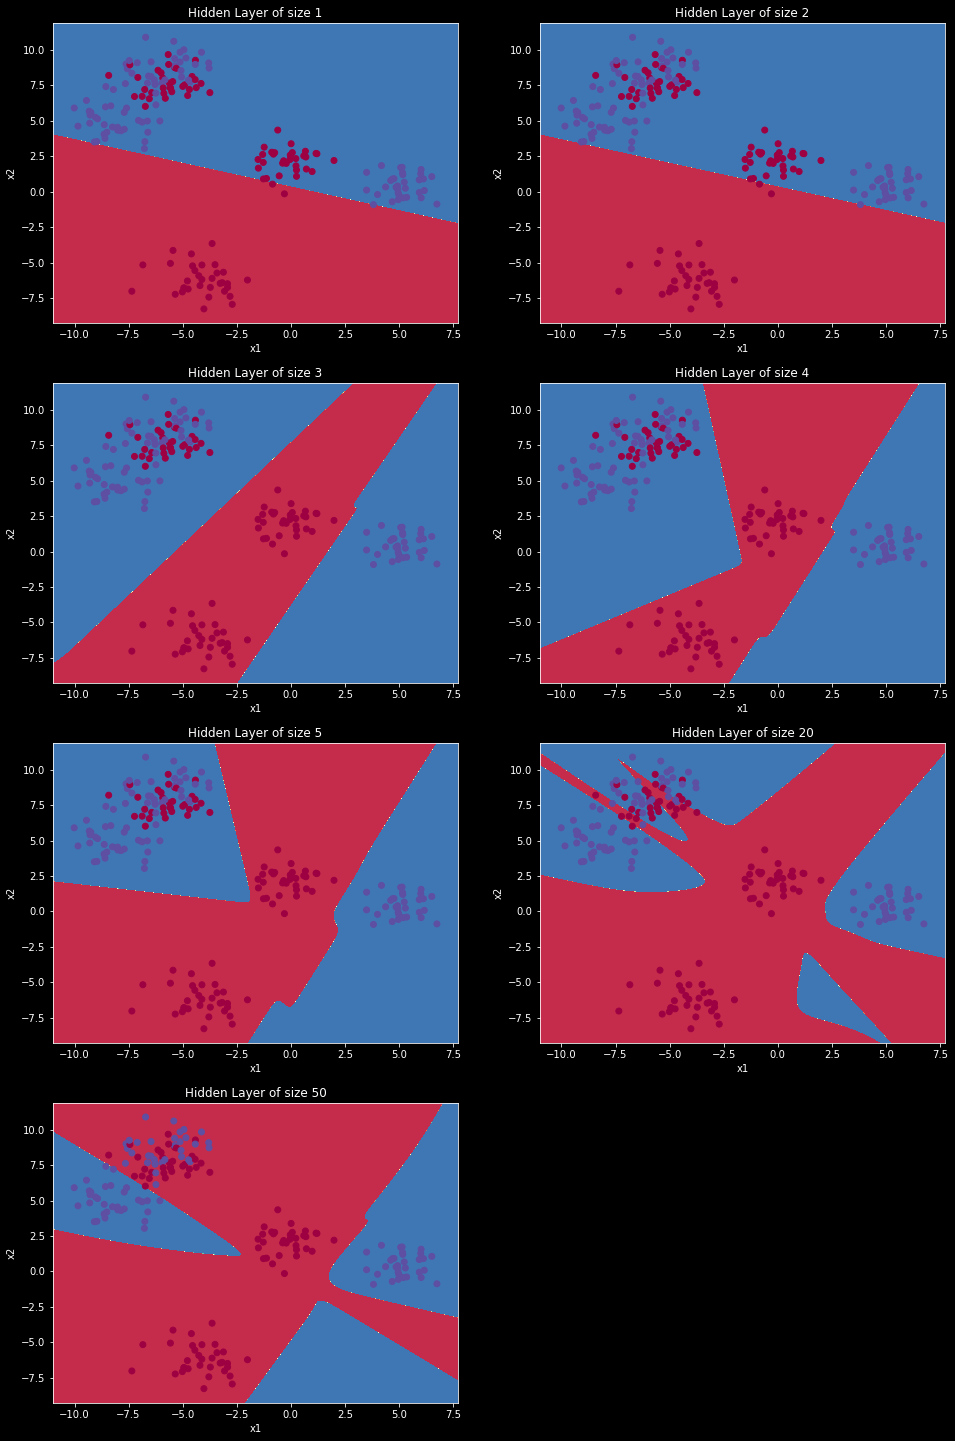

In [25]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h,1.2, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))